# Construction des BDD pour le Machine Learning/régression

Dans ce notebook, nous allons encoder les variables catégorielles des bdd à l'aide du one hot encoding pour pouvoir utiliser les variables catégorielles dans les régressions.

In [14]:
%pip install xgboost

     |████████████████████████████████| 1.8 MB 3.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [54]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import sklearn.preprocessing 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import datetime
from sklearn.metrics import r2_score

In [125]:
## Chemin Jérémie
enedis_IDF_6 = pd.read_csv("/Users/jeremiedarracq/Stat-app/data_conso_6kvaIDF.csv")
enedis_HDF_6 = pd.read_csv("/Users/jeremiedarracq/Stat-app/data_conso_6kvaHDF.csv")
enedis_PACA_6 = pd.read_csv("/Users/jeremiedarracq/Stat-app/data_conso_6kvaPACA.csv")
enedis_final_6kva=pd.read_csv("/Users/jeremiedarracq/Stat-app/enedis_filtered_6kva.csv",sep=",")

## Chemin Elena 
#enedis_IDF_6=pd.read_csv("Données/data_conso_moyenne/data_conso_6kva_IDF.csv")
#enedis_HDF_6=pd.read_csv("Données/data_conso_moyenne/data_conso_6kva_HDF.csv")
#enedis_PACA_6=pd.read_csv("Données/data_conso_moyenne/data_conso_6kva_PACA.csv")

## 1. Construction de la bdd pour "Jour" :

In [8]:
def creation_bdd_one_hot_jour(bdd_region,nom_court,kva):
    # Création d'un ensemble de données fictif avec une variable catégorielle
    Xdate =bdd_region["date"].to_numpy()
    Xdate=Xdate.reshape(-1, 1)

    # Création de l'objet OneHotEncoder
    encoder = OneHotEncoder()

    # Encodage des données avec OneHotEncoder
    X_encoded = encoder.fit_transform(Xdate)
    oneHot=pd.DataFrame(X_encoded.toarray(),index=bdd_region.index,columns=["jour_"+str(i+1) for i in range(len(X_encoded.toarray()))])
    oneHot["indice"]=oneHot.index
    bdd_region["indice"]=bdd_region.index
    bdd_region=bdd_region.merge(oneHot,on="indice")
    ## Chemin Elena
    #bdd_region.to_csv("Données/data_one_hot_encoded/data_one_hot_encoded_jour_"+kva+"_"+nom_court+".csv",index=False)
    ## Chemin Jérémie 
    bdd_region.to_csv("/Users/jeremiedarracq/Stat-app/data_one_hot_encoded_jour_"+kva+"_"+nom_court+".csv",index=False)


In [9]:
creation_bdd_one_hot_jour(enedis_IDF_6,"IDF",'6kva')
creation_bdd_one_hot_jour(enedis_HDF_6,"HDF",'6kva')
creation_bdd_one_hot_jour(enedis_PACA_6,"PACA",'6kva')

## 2. Construction de la bdd pour "heure par 30min" et "mois" :

On construit d'abord la bdd de conso moyenne par 30 min :

In [160]:
def bdd_30min(enedis_final,region):    
    conso_region=enedis_final[enedis_final["region_x"]==region]
    temperature=enedis_final[["date","region_x","tmoy",'horodate']]
    temperature_region=temperature[temperature.region_x==region]
    temperature_region.drop_duplicates(inplace=True)
    temperature_region = temperature_region.reset_index()


    conso_region["heure"]=conso_region["horodate"].apply(lambda x : x[11:16])

    nb_contrat=conso_region.nb_points_soutirage.mean()

    total_conso_region=conso_region.groupby(["date","heure"])["total_energie_soutiree_wh"].sum().reset_index() # pour chaque jour, on calcule la conso totale pour chaque heure
    total_conso_region["mois"]=total_conso_region["date"].apply(lambda x : x[5:7])
    total_conso_region["res_conso_moyenne"]=total_conso_region.total_energie_soutiree_wh/nb_contrat # conso moyenne soutirée par contrat pour chaque 30min

    total_conso_region= pd.merge(total_conso_region, temperature_region, left_index=True, right_index=True)
    total_conso_region["date"] = total_conso_region["date_x"]
    total_conso_region = total_conso_region.drop(["index","date_y","horodate","date_x"],axis=1)

    return(total_conso_region)

In [161]:
conso_IDF = enedis_final_6kva[enedis_final_6kva["region_x"]=="Île-de-France"]
temperature= enedis_final_6kva[["date","region_x","tmoy",'horodate']]

temperature_IDF=temperature[temperature.region_x=="Île-de-France"]
temperature_IDF.drop_duplicates(inplace=True)

conso_IDF["heure"]=conso_IDF["horodate"].apply(lambda x : x[11:16])
nb_contrat=conso_IDF.nb_points_soutirage.mean()
total_conso_region = conso_IDF.groupby(["date","heure"])["total_energie_soutiree_wh"].sum().reset_index()
total_conso_region["mois"]=total_conso_region["date"].apply(lambda x : x[5:7])
total_conso_region["res_conso_moyenne"]=total_conso_region.total_energie_soutiree_wh/nb_contrat
total_conso_region

<ipython-input-161-6f7a264821fd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_IDF.drop_duplicates(inplace=True)
<ipython-input-161-6f7a264821fd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_IDF["heure"]=conso_IDF["horodate"].apply(lambda x : x[11:16])


,date,heure,total_energie_soutiree_wh,mois,res_conso_moyenne
0,2020-06-04,00:00,55228733.0,06,107.852552
1,2020-06-04,00:30,53298530.0,06,104.083186
2,2020-06-04,01:00,52609821.0,06,102.738252
3,2020-06-04,01:30,51404043.0,06,100.383567
4,2020-06-04,02:30,51462261.0,06,100.497258
...,...,...,...,...,...
10251,2021-07-30,20:30,78171203.0,07,152.655390
10252,2021-07-30,21:00,72127907.0,07,140.853835
10253,2021-07-30,21:30,66916954.0,07,130.677709
10254,2021-07-30,22:30,57894869.0,07,113.059074


In [162]:
temperature_IDF = temperature_IDF.reset_index()
temperature_IDF
total_conso_region = pd.merge(total_conso_region, temperature_IDF, left_index=True, right_index=True)
total_conso_region

,date_x,heure,total_energie_soutiree_wh,mois,res_conso_moyenne,index,date_y,region_x,tmoy,horodate
0,2020-06-04,00:00,55228733.0,06,107.852552,6,2020-06-04,Île-de-France,14.51,2020-06-04T00:00:00+00:00
1,2020-06-04,00:30,53298530.0,06,104.083186,17,2020-06-04,Île-de-France,14.51,2020-06-04T00:30:00+00:00
2,2020-06-04,01:00,52609821.0,06,102.738252,18,2020-06-04,Île-de-France,14.51,2020-06-04T01:00:00+00:00
3,2020-06-04,01:30,51404043.0,06,100.383567,28,2020-06-04,Île-de-France,14.51,2020-06-04T01:30:00+00:00
4,2020-06-04,02:30,51462261.0,06,100.497258,46,2020-06-04,Île-de-France,14.51,2020-06-04T02:30:00+00:00
...,...,...,...,...,...,...,...,...,...,...
10251,2021-07-30,20:30,78171203.0,07,152.655390,122197,2021-07-30,Île-de-France,18.68,2021-07-30T20:30:00+00:00
10252,2021-07-30,21:00,72127907.0,07,140.853835,122200,2021-07-30,Île-de-France,18.68,2021-07-30T21:00:00+00:00
10253,2021-07-30,21:30,66916954.0,07,130.677709,122206,2021-07-30,Île-de-France,18.68,2021-07-30T21:30:00+00:00
10254,2021-07-30,22:30,57894869.0,07,113.059074,122222,2021-07-30,Île-de-France,18.68,2021-07-30T22:30:00+00:00


In [163]:
enedis_IDF_30=bdd_30min(enedis_final_6kva,"Île-de-France")
enedis_HDF_30=bdd_30min(enedis_final_6kva,"Hauts-de-France")
enedis_PACA_30=bdd_30min(enedis_final_6kva,"Provence-Alpes-Côte d'Azur")

<ipython-input-160-e896fa68071f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_region.drop_duplicates(inplace=True)
<ipython-input-160-e896fa68071f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_region["heure"]=conso_region["horodate"].apply(lambda x : x[11:16])


In [165]:
def creation_bdd_one_hot_heure_mois(bdd_region,nom_court,kva):
    # Création d'un ensemble de données fictif avec une variable catégorielle
    Xheure =bdd_region["heure"].to_numpy()
    Xheure=Xheure.reshape(-1, 1)

    Xmois =bdd_region["mois"].to_numpy()
    Xmois=Xmois.reshape(-1, 1)

    # Création de l'objet OneHotEncoder
    encoder = OneHotEncoder()

    # Encodage des données avec OneHotEncoder
    X_encoded_heure = encoder.fit_transform(Xheure)

    oneHot_heure=pd.DataFrame(X_encoded_heure.toarray(),index=bdd_region.index,columns=["heure_"+str(i+1) for i in range(X_encoded_heure.shape[1])])
    oneHot_heure["indice"]=oneHot_heure.index
    bdd_region["indice"]=bdd_region.index
    bdd_region=bdd_region.merge(oneHot_heure,on="indice")
    

    X_encoded_mois = encoder.fit_transform(Xmois)

    oneHot_mois=pd.DataFrame(X_encoded_mois.toarray(),index=bdd_region.index,columns=["mois_"+str(i+1) for i in range(X_encoded_mois.shape[1])])
    oneHot_mois["indice"]=oneHot_mois.index

    bdd_region=bdd_region.merge(oneHot_mois,on="indice")
    ## Chemin Elena 
    #bdd_region.to_csv("Données/data_one_hot_encoded/data_one_hot_encoded_heure_mois_"+kva+"_"+nom_court+".csv",index=False)
    ## Chemin Jérémie 
    bdd_region.to_csv("/Users/jeremiedarracq/Stat-app/data_one_hot_encoded_heure_mois_"+kva+"_"+nom_court+".csv",index=False)



In [166]:
creation_bdd_one_hot_heure_mois(enedis_IDF_30,"IDF",'6kva')
creation_bdd_one_hot_heure_mois(enedis_HDF_30,"HDF",'6kva')
creation_bdd_one_hot_heure_mois(enedis_PACA_30,"PACA",'6kva')

## Partie Machine Learning 2 ( XG boost)

In [196]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [197]:
enedis_IDF_30_ML = pd.read_csv("/Users/jeremiedarracq/Stat-app/data_one_hot_encoded_heure_mois_6kva_IDF.csv")


In [198]:
enedis_IDF_30_ML = pd.read_csv("/Users/jeremiedarracq/Stat-app/data_one_hot_encoded_heure_mois_6kva_IDF.csv")
enedis_IDF_30_ML = enedis_IDF_30_ML.drop(["mois","region_x","total_energie_soutiree_wh","indice","mois_1","mois_2","mois_3","mois_4","mois_5","mois_6","mois_7","mois_8","mois_9","mois_10","mois_11","mois_12","heure_1","heure_2","heure_3","heure_4","heure_5","heure_6","heure_7","heure_8","heure_9","heure_10","heure_11","heure_12","heure_13","heure_14","heure_15","heure_16","heure_17","heure_18","heure_19","heure_20","heure_21","heure_22","heure_23","heure_24","heure_25","heure_26","heure_27","heure_28","heure_29","heure_30","heure_31","heure_32","heure_33","heure_34","heure_35","heure_36","heure_37","heure_38","heure_39","heure_40","heure_41","heure_42","heure_43","heure_44","heure_45","heure_46","heure_47","heure_48"],axis=1)
enedis_IDF_30_ML["horodate"] = enedis_IDF_30_ML["date"] + enedis_IDF_30_ML["heure"]
enedis_IDF_30_ML = enedis_IDF_30_ML.drop(["date","heure"],axis=1)
split_date = "2021-06-04"
enedis_IDF_30_ML_train = enedis_IDF_30_ML.loc[enedis_IDF_30_ML["horodate" ]< split_date].copy()
enedis_IDF_30_ML_test = enedis_IDF_30_ML.loc[enedis_IDF_30_ML["horodate" ]> split_date].copy()
enedis_IDF_30_ML_train["horodate"]=enedis_IDF_30_ML_train["horodate"].apply(lambda x : x[0:16])
enedis_IDF_30_ML_test["horodate"]=enedis_IDF_30_ML_test["horodate"].apply(lambda x : x[0:16])
enedis_IDF_30_ML_test["horodate"] = enedis_IDF_30_ML_test["horodate"].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d%H:%M"))
enedis_IDF_30_ML_train["horodate"] = enedis_IDF_30_ML_train["horodate"].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d%H:%M"))



In [201]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['horodate'].dt.hour
    df['dayofweek'] = df['horodate'].dt.dayofweek
    df['month'] = df['horodate'].dt.month
    df['dayofyear'] = df['horodate'].dt.dayofyear
    df['dayofmonth'] = df['horodate'].dt.day
    df['weekofyear'] = df['horodate'].dt.weekofyear
    df["minute"] = df["horodate"].dt.minute
    df['conso_6_hrs_lag'] = df['res_conso_moyenne'].shift(6)
    df['conso_12_hrs_lag'] = df['res_conso_moyenne'].shift(12)
    df['conso_24_hrs_lag'] = df['res_conso_moyenne'].shift(24)
    df['conso_6_hrs_mean'] = df['res_conso_moyenne'].rolling(window = 6).mean()
    df['conso_12_hrs_mean'] = df['res_conso_moyenne'].rolling(window = 12).mean()
    df['conso_24_hrs_mean'] = df['res_conso_moyenne'].rolling(window = 24).mean()
    df['conso_6_hrs_std'] = df['res_conso_moyenne'].rolling(window = 6).std()
    df['conso_12_hrs_std'] = df['res_conso_moyenne'].rolling(window = 12).std()
    df['conso_24_hrs_std'] = df['res_conso_moyenne'].rolling(window = 24).std()
    df['conso_6_hrs_max'] = df['res_conso_moyenne'].rolling(window = 6).max()
    df['conso_12_hrs_max'] = df['res_conso_moyenne'].rolling(window = 12).max()
    df['conso_24_hrs_max'] = df['res_conso_moyenne'].rolling(window = 24).max()
    df['conso_6_hrs_min'] = df['res_conso_moyenne'].rolling(window = 6).min()
    df['conso_12_hrs_min'] = df['res_conso_moyenne'].rolling(window = 12).min()
    df['conso_24_hrs_min'] = df['res_conso_moyenne'].rolling(window = 24).min()
    
    X = df[['hour','dayofweek','minute','month',
           'dayofyear','dayofmonth','weekofyear',"tmoy",'conso_6_hrs_lag' , 'conso_24_hrs_lag' , 'conso_6_hrs_mean',
           "conso_12_hrs_mean" ,"conso_24_hrs_mean" ,"conso_6_hrs_std" ,"conso_12_hrs_std" ,"conso_24_hrs_std",
           "conso_6_hrs_max","conso_12_hrs_max" ,"conso_24_hrs_max" ,"conso_6_hrs_min","conso_12_hrs_min" ,"conso_24_hrs_min"]]
    if label:
        y = df[label]
        return X, y
    return X

In [202]:
X_train, y_train = create_features(enedis_IDF_30_ML_train, label='res_conso_moyenne')
X_test, y_test = create_features(enedis_IDF_30_ML_test, label='res_conso_moyenne')

<ipython-input-201-54f3824a6a91>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['horodate'].dt.weekofyear


In [203]:
X_train

,hour,dayofweek,minute,month,dayofyear,dayofmonth,weekofyear,tmoy,conso_6_hrs_lag,conso_24_hrs_lag,...,conso_24_hrs_mean,conso_6_hrs_std,conso_12_hrs_std,conso_24_hrs_std,conso_6_hrs_max,conso_12_hrs_max,conso_24_hrs_max,conso_6_hrs_min,conso_12_hrs_min,conso_24_hrs_min
0,0,3,0,6,156,4,23,14.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,3,30,6,156,4,23,14.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,0,6,156,4,23,14.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3,30,6,156,4,23,14.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,3,30,6,156,4,23,14.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,20,3,0,6,154,3,22,22.17,199.122257,227.732899,...,162.192055,22.839051,35.822271,42.780588,222.725692,222.725692,234.090858,164.168261,101.838257,101.238206
8892,21,3,0,6,154,3,22,22.17,170.549994,234.090858,...,158.933527,25.454999,28.688306,39.950841,222.725692,222.725692,226.626042,155.886200,107.707662,101.238206
8893,22,3,0,6,154,3,22,22.17,164.168261,226.626042,...,154.957234,32.933147,23.854566,37.600469,222.725692,222.725692,222.725692,131.195007,131.195007,101.238206
8894,23,3,0,6,154,3,22,22.17,169.898345,197.858148,...,151.431125,42.477112,30.548065,37.369736,222.725692,222.725692,222.725692,113.231523,113.231523,101.238206


In [204]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/Users/jeremiedarracq/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

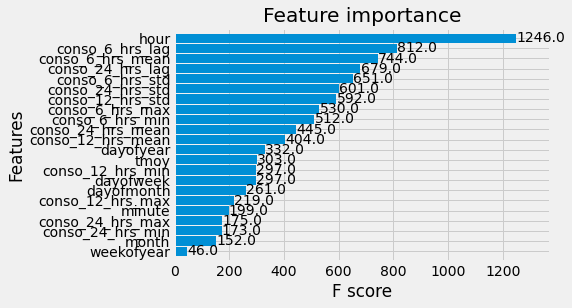

In [205]:
_ = plot_importance(reg, height=0.9)

In [206]:
enedis_IDF_30_ML_test['Conso_prediction'] = reg.predict(X_test)

enedis_all = pd.concat([enedis_IDF_30_ML_train, enedis_IDF_30_ML_test], sort=False)
enedis_all

,res_conso_moyenne,tmoy,horodate,date,hour,dayofweek,month,dayofyear,dayofmonth,weekofyear,...,conso_6_hrs_std,conso_12_hrs_std,conso_24_hrs_std,conso_6_hrs_max,conso_12_hrs_max,conso_24_hrs_max,conso_6_hrs_min,conso_12_hrs_min,conso_24_hrs_min,Conso_prediction
0,107.852552,14.51,2020-06-04 00:00:00,0,0,3,6,156,4,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.083186,14.51,2020-06-04 00:30:00,1,0,3,6,156,4,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,102.738252,14.51,2020-06-04 01:00:00,2,1,3,6,156,4,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100.383567,14.51,2020-06-04 01:30:00,3,1,3,6,156,4,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100.497258,14.51,2020-06-04 02:30:00,4,2,3,6,156,4,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10251,152.655390,18.68,2021-07-30 20:30:00,10251,20,4,7,211,30,30,...,13.519918,11.155244,33.598482,191.706776,191.706776,196.45282,152.655390,152.655390,92.440094,162.163132
10252,140.853835,18.68,2021-07-30 21:00:00,10252,21,4,7,211,30,30,...,14.200526,13.462049,31.348061,178.334912,191.706776,196.45282,140.853835,140.853835,92.440094,143.976715
10253,130.677709,18.68,2021-07-30 21:30:00,10253,21,4,7,211,30,30,...,16.949681,16.845776,28.903687,173.925311,191.706776,196.45282,130.677709,130.677709,92.440094,130.636673
10254,113.059074,18.68,2021-07-30 22:30:00,10254,22,4,7,211,30,30,...,21.086463,22.250992,27.115409,170.383665,191.706776,196.45282,113.059074,113.059074,92.969523,112.275352


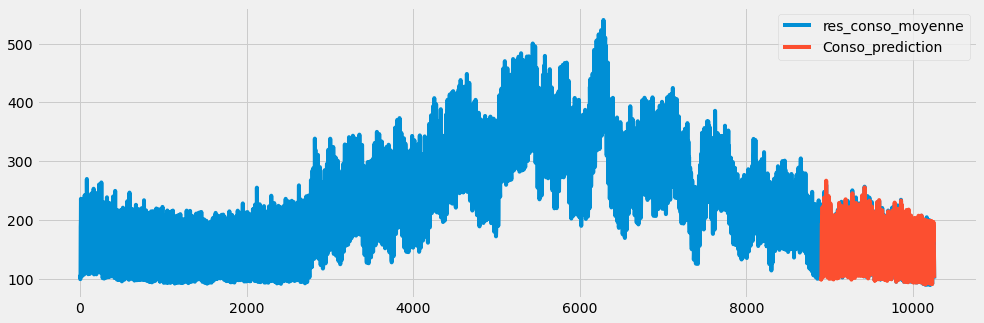

In [207]:
_ = enedis_all[['res_conso_moyenne','Conso_prediction']].plot(figsize=(15, 5))

In [208]:
mean_squared_error(y_true=enedis_IDF_30_ML_test['res_conso_moyenne'],
                   y_pred=enedis_IDF_30_ML_test['Conso_prediction'])

25.01041810044558

In [209]:
r2_score(y_true=enedis_IDF_30_ML_test['res_conso_moyenne'],
                   y_pred=enedis_IDF_30_ML_test['Conso_prediction'])

0.9846196762659737

In [210]:
enedis_IDF_30_ML_test

,res_conso_moyenne,tmoy,horodate,date,hour,dayofweek,month,dayofyear,dayofmonth,weekofyear,...,conso_6_hrs_std,conso_12_hrs_std,conso_24_hrs_std,conso_6_hrs_max,conso_12_hrs_max,conso_24_hrs_max,conso_6_hrs_min,conso_12_hrs_min,conso_24_hrs_min,Conso_prediction
8896,105.788604,18.39,2021-06-04 00:00:00,8896,0,4,6,155,4,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.094185
8897,103.126729,18.39,2021-06-04 00:30:00,8897,0,4,6,155,4,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.971359
8898,101.276276,18.39,2021-06-04 01:00:00,8898,1,4,6,155,4,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.115532
8899,101.583771,18.39,2021-06-04 02:30:00,8899,2,4,6,155,4,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.827126
8900,105.738463,18.39,2021-06-04 03:00:00,8900,3,4,6,155,4,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.980865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10251,152.655390,18.68,2021-07-30 20:30:00,10251,20,4,7,211,30,30,...,13.519918,11.155244,33.598482,191.706776,191.706776,196.45282,152.655390,152.655390,92.440094,162.163132
10252,140.853835,18.68,2021-07-30 21:00:00,10252,21,4,7,211,30,30,...,14.200526,13.462049,31.348061,178.334912,191.706776,196.45282,140.853835,140.853835,92.440094,143.976715
10253,130.677709,18.68,2021-07-30 21:30:00,10253,21,4,7,211,30,30,...,16.949681,16.845776,28.903687,173.925311,191.706776,196.45282,130.677709,130.677709,92.440094,130.636673
10254,113.059074,18.68,2021-07-30 22:30:00,10254,22,4,7,211,30,30,...,21.086463,22.250992,27.115409,170.383665,191.706776,196.45282,113.059074,113.059074,92.969523,112.275352


In [211]:
enedis_IDF_30_ML_test['error'] = enedis_IDF_30_ML_test['res_conso_moyenne'] - enedis_IDF_30_ML_test['Conso_prediction']
enedis_IDF_30_ML_test['abs_error'] = enedis_IDF_30_ML_test['error'].apply(np.abs)
error_by_day = enedis_IDF_30_ML_test.groupby(['month','dayofmonth',"dayofyear"]).mean()[["res_conso_moyenne","Conso_prediction","error","abs_error"]]

In [213]:
# Best absolute predicted day 
error_by_day.sort_values('abs_error', ascending=True).head(10)

res_conso_moyenne  Conso_prediction     error  \
month dayofmonth dayofyear                                                  
7     13         194               165.849524        165.790161  0.059363   
      16         197               150.740983        151.166809 -0.425821   
      6          187               157.649214        158.082260 -0.433051   
      20         201               157.000441        158.508453 -1.508019   
      12         193               164.827366        163.318420  1.508939   
      21         202               153.052905        154.348923 -1.296013   
      9          190               159.928260        160.420639 -0.492382   
      27         208               146.528493        147.425018 -0.896527   
      4          185               154.102909        154.140030 -0.037119   
      5          186               162.046043        161.779602  0.266434   

                            abs_error  
month dayofmonth dayofyear             
7     13         194         1.767200  
      16         197         1.914185  
      6          187         1.973178  
      20         201         2.089363  
      12         193         2.108573  
      21         202         2.170096  
      9          190         2.271268  
      27         208         2.332516  
      4          185         2.353152  
      5          186         2.522240

In [214]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

res_conso_moyenne  Conso_prediction     error  \
month dayofmonth dayofyear                                                  
6     20         171               166.800740        169.816986 -3.016248   
      6          157               181.033531        185.151398 -4.117864   
      21         172               177.442143        180.788742 -3.346599   
      26         177               177.975626        179.992920 -2.017300   
      22         173               177.860636        176.095871  1.764760   
      28         179               181.124685        179.764435  1.360244   
      15         166               164.609301        161.467834  3.141467   
      29         180               176.829346        174.526794  2.302549   
7     11         192               170.834576        173.923737 -3.089161   
6     19         170               182.774103        179.602661  3.171445   

                            abs_error  
month dayofmonth dayofyear             
6     20         171         6.930705  
      6          157         6.529355  
      21         172         6.301026  
      26         177         5.895864  
      22         173         4.864227  
      28         179         4.581477  
      15         166         4.575672  
      29         180         4.528730  
7     11         192         4.524799  
6     19         170         4.521144

In [216]:
enedis_IDF_30_ML_test_best_predicted_day = enedis_IDF_30_ML_test[enedis_IDF_30_ML_test["dayofyear"]==194]

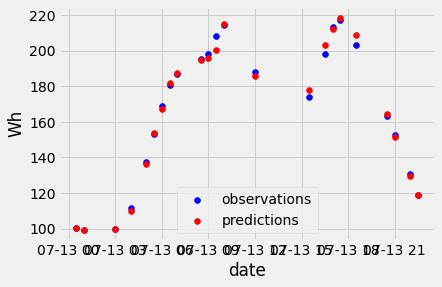

In [217]:
# Best predicted days
plt.scatter(enedis_IDF_30_ML_test_best_predicted_day["horodate"],enedis_IDF_30_ML_test_best_predicted_day["res_conso_moyenne"],label="observations",color="blue")
plt.scatter(enedis_IDF_30_ML_test_best_predicted_day["horodate"],enedis_IDF_30_ML_test_best_predicted_day["Conso_prediction"],label="predictions",color="red")
plt.xlabel("date")
plt.ylabel("Wh")
plt.legend()

In [218]:
## Worst predicted day
enedis_IDF_30_ML_test_worst_predicted_day = enedis_IDF_30_ML_test[enedis_IDF_30_ML_test["dayofyear"]==171]
enedis_IDF_30_ML_test_worst_predicted_day 

,res_conso_moyenne,tmoy,horodate,date,hour,dayofweek,month,dayofyear,dayofmonth,weekofyear,...,conso_24_hrs_std,conso_6_hrs_max,conso_12_hrs_max,conso_24_hrs_max,conso_6_hrs_min,conso_12_hrs_min,conso_24_hrs_min,Conso_prediction,error,abs_error
9261,114.214300,20.27,2021-06-20 00:30:00,9261,0,6,6,171,20,24,...,45.093873,224.119066,228.468127,228.468127,114.214300,114.214300,106.871070,99.553749,14.660551,14.660551
9262,110.853879,20.27,2021-06-20 01:00:00,9262,1,6,6,171,20,24,...,46.586982,224.119066,224.119066,228.468127,110.853879,110.853879,106.871070,109.328384,1.525494,1.525494
9263,109.627159,20.27,2021-06-20 02:00:00,9263,2,6,6,171,20,24,...,47.598627,206.471865,224.119066,228.468127,109.627159,109.627159,106.871070,108.887939,0.739220,0.739220
9264,108.338611,20.27,2021-06-20 02:30:00,9264,2,6,6,171,20,24,...,48.072736,196.323576,224.119066,228.468127,108.338611,108.338611,106.871070,110.509659,-2.171048,2.171048
9265,116.353349,20.27,2021-06-20 04:00:00,9265,4,6,6,171,20,24,...,47.560966,119.850888,224.119066,228.468127,108.338611,108.338611,108.338611,106.872231,9.481118,9.481118
9266,122.947649,20.27,2021-06-20 04:30:00,9266,4,6,6,171,20,24,...,46.826846,122.947649,224.119066,228.468127,108.338611,108.338611,108.338611,121.527603,1.420046,1.420046
9267,133.177918,20.27,2021-06-20 05:00:00,9267,5,6,6,171,20,24,...,45.708179,133.177918,224.119066,228.468127,108.338611,108.338611,108.338611,136.940857,-3.762939,3.762939
9268,147.044730,20.27,2021-06-20 05:30:00,9268,5,6,6,171,20,24,...,44.465497,147.044730,224.119066,228.468127,108.338611,108.338611,108.338611,154.747513,-7.702783,7.702783
9269,166.941543,20.27,2021-06-20 06:00:00,9269,6,6,6,171,20,24,...,44.487480,166.941543,206.471865,228.468127,108.338611,108.338611,108.338611,169.218933,-2.277390,2.277390
9270,183.091483,20.27,2021-06-20 06:30:00,9270,6,6,6,171,20,24,...,44.151407,183.091483,196.323576,228.468127,116.353349,108.338611,108.338611,184.236465,-1.144983,1.144983


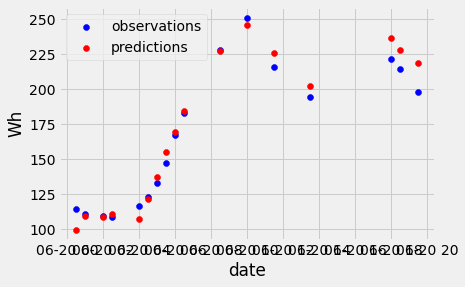

In [219]:
plt.scatter(enedis_IDF_30_ML_test_worst_predicted_day["horodate"],enedis_IDF_30_ML_test_worst_predicted_day["res_conso_moyenne"],label="observations",color="blue")
plt.scatter(enedis_IDF_30_ML_test_worst_predicted_day["horodate"],enedis_IDF_30_ML_test_worst_predicted_day["Conso_prediction"],label="predictions",color="red")
plt.xlabel("date")
plt.ylabel("Wh")
plt.legend()